# Tiền xử lí

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from google.colab import drive
drive.mount('/content/drive')
print('hoàn tất')

Mounted at /content/drive
hoàn tất


In [2]:
H,L=1440,2560
H,L=int(H/4),int(L/4)

Text(0.5, 1.0, 'kích thước:(1, 360, 640, 3)')

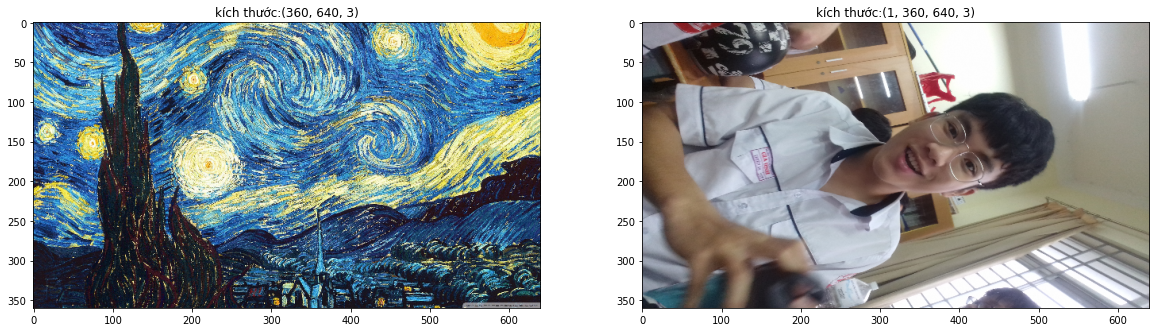

In [3]:
org_image=tf.constant(plt.imread('//content//drive//MyDrive//Colab Notebooks//org_image.jpg'))/255
st_image=tf.constant(plt.imread('//content//drive//MyDrive//Colab Notebooks//st_image.jpg'))/255
org_image=tf.constant(cv2.resize(org_image.numpy(),(L,H)))
st_image=tf.constant(cv2.resize(st_image.numpy(),(L,H)))
fig,ax=plt.subplots(1,2,figsize=(20,40))
ax[0].imshow(st_image.numpy())
ax[0].set_title('kích thước:'+str(st_image.shape))
st_image=tf.reshape(st_image,(1,H,L,3))
ax[1].imshow(org_image.numpy())
org_image=tf.reshape(org_image,(1,H,L,3))
ax[1].set_title('kích thước:'+str(org_image.shape))

In [4]:
my_vgg=keras.applications.VGG16(include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [5]:
my_vgg.trainable=False
my_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [6]:
def get_layer_feature(model,layer=-2):
  if type(layer)==int:
    mymodel=keras.Model(inputs=model.inputs,outputs=model.layers[layer].output)
  else:
    mymodel=keras.Model(inputs=model.inputs,outputs=[model.layers[layers].output for layers in layer])
  return mymodel
test=get_layer_feature(my_vgg,layer=-2)
u=test.predict(org_image)
print(tf.shape(u))

tf.Tensor([  1  22  40 512], shape=(4,), dtype=int32)


In [7]:
def rescale(im):
  return ((im-np.min(im))/(np.max(im)-np.min(im)))

In [8]:
def post_pross(image):
  idx=np.where(image>1)
  image[idx]=1
  idx=np.where(image<0)
  image[idx]=0
  return image

In [9]:
def gram_matrix(x):
    x = tf.transpose(x, perm=[2, 0, 1])
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [10]:
st=gram_matrix(test(tf.reshape(st_image,(1,H,L,3)))[0])
#or_siz=tf.cast(tf.reduce_prod(tf.shape(org_image)),tf.float32)
#st_siz=tf.cast(tf.reduce_prod(tf.shape(st_image)),tf.float32)
def lossfunc(org,style,image,model,xi):
  im=gram_matrix(model(tf.reshape(image,(1,H,L,3)))[0])
  return tf.reduce_sum((image-org)**2)+xi*tf.reduce_sum(tf.abs(im-st)) 

In [11]:
@tf.function
def grad_step(org,style,image,lr,xi,model,lossfunc):
  loss = tf.zeros(shape=(),dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss=lossfunc(org,style,image,model,xi)
  grads=tape.gradient(loss,image)
  #print(grads)
  #print(image)
  #image-=lr*grads

  return grads,loss

In [12]:
def loop_4_grad_ascent(org,style,image,model,lossfunc,max_itter,lr,xi,stop_loss=None):
  optimizer=keras.optimizers.SGD(lr=lr)
  for itter in range(max_itter):
    grads,loss=grad_step(org,style,image,lr,xi,model,lossfunc)
    optimizer.apply_gradients(zip([grads],[image]))
    if stop_loss is not None and loss > stop_loss:
      break
    print('itter thứ',itter,'giá trị của loss là: ',loss.numpy())
  return image

# Huấn luyện chay

In [19]:
org_image=tf.reshape(tf.cast(org_image,tf.float32),(1,H,L,3))
st_image=tf.reshape(tf.cast(st_image,tf.float32),(1,H,L,3))
init=tf.Variable(tf.zeros_like(org_image,dtype=tf.float32))
ima=loop_4_grad_ascent(org_image,st_image,init,test,lossfunc,500,0.0001,50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


itter thứ 0 giá trị của loss là:  127288310.0
itter thứ 1 giá trị của loss là:  139640640.0
itter thứ 2 giá trị của loss là:  159115380.0
itter thứ 3 giá trị của loss là:  122399790.0
itter thứ 4 giá trị của loss là:  105090696.0
itter thứ 5 giá trị của loss là:  105711690.0
itter thứ 6 giá trị của loss là:  110637350.0
itter thứ 7 giá trị của loss là:  96938344.0
itter thứ 8 giá trị của loss là:  95649090.0
itter thứ 9 giá trị của loss là:  95259470.0
itter thứ 10 giá trị của loss là:  94981400.0
itter thứ 11 giá trị của loss là:  94821960.0
itter thứ 12 giá trị của loss là:  97147420.0
itter thứ 13 giá trị của loss là:  82552376.0
itter thứ 14 giá trị của loss là:  85026616.0
itter thứ 15 giá trị của loss là:  78237810.0
itter thứ 16 giá trị của loss là:  88106450.0
itter thứ 17 giá trị của loss là:  77591176.0
itter thứ 18 giá trị của loss là:  79579976.0
itter thứ 19 giá trị của loss là:  65691652.0
itter thứ 20 giá trị của loss là:  74641320.0
itter thứ 21 giá trị của loss là:  63

In [20]:
import matplotlib
matplotlib.image.imsave('art.jpg',rescale(ima.numpy()).astype('uint8'))

tf.Tensor(3434999.8, shape=(), dtype=float32)


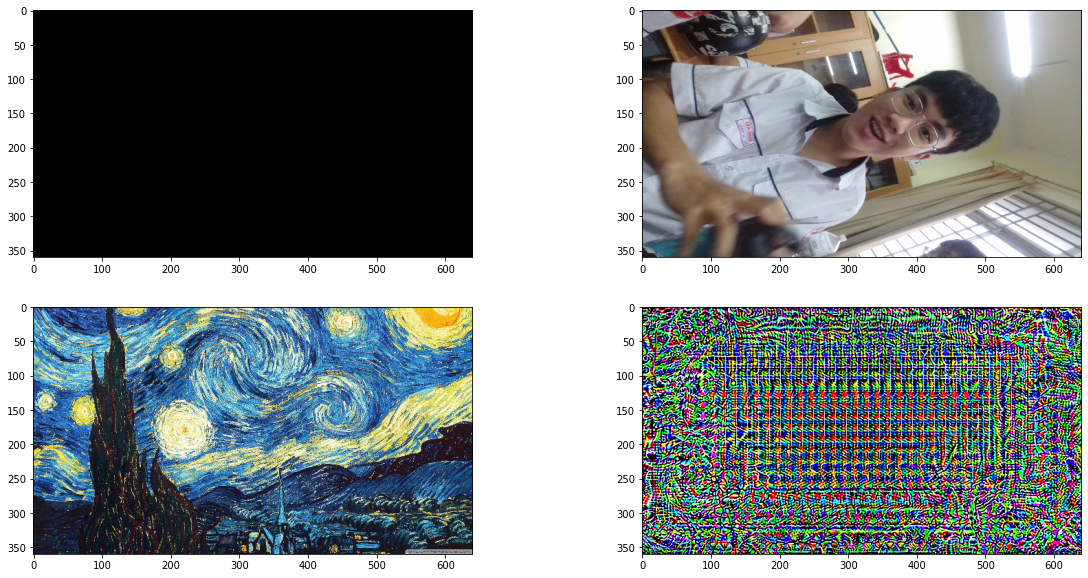

In [21]:
print(lossfunc(org_image,st_image,ima,test,5))
fig,ax=plt.subplots(2,2,figsize=(20,10))
ax[1,1].imshow(post_pross(ima.numpy()[0]))
ax[0,1].imshow(org_image.numpy()[0])
ax[1,0].imshow(st_image.numpy()[0])
ax[0,0].imshow(np.zeros((H,L,3)))

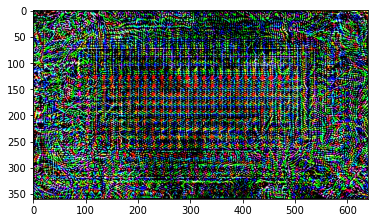

In [22]:
res=ima-org_image
plt.imshow(post_pross(res.numpy())[0])
#rescale(res.numpy())

In [23]:
sty=gram_matrix(test(tf.reshape(st_image,(1,H,L,3)))[0])
orgy=test(tf.reshape(org_image,(1,H,L,3)))[0]
def lossfunc_content(org,style,image,model,xi):
  im_st=gram_matrix(model(tf.reshape(image,(1,H,L,3)))[0])
  org_ct=model(tf.reshape(image,(1,H,L,3)))
  return tf.reduce_mean(tf.square(image-org))+xi[0]*tf.reduce_mean(tf.square(org_ct-orgy))+xi[1]*tf.reduce_mean(tf.square(im_st-sty))

In [25]:
org_image=tf.reshape(tf.cast(org_image,tf.float32),(H,L,3))
st_image=tf.reshape(tf.cast(st_image,tf.float32),(H,L,3))
init=tf.Variable(tf.zeros_like(org_image,dtype=tf.float32))
ima_new=loop_4_grad_ascent(org_image,st_image,init,test,lossfunc_content,500,1,[1,2])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


itter thứ 0 giá trị của loss là:  15377.981
itter thứ 1 giá trị của loss là:  16595.191
itter thứ 2 giá trị của loss là:  18341.195
itter thứ 3 giá trị của loss là:  13896.798
itter thứ 4 giá trị của loss là:  9179.208
itter thứ 5 giá trị của loss là:  7622.8296
itter thứ 6 giá trị của loss là:  6625.2915
itter thứ 7 giá trị của loss là:  5109.762
itter thứ 8 giá trị của loss là:  4512.796
itter thứ 9 giá trị của loss là:  5898.407
itter thứ 10 giá trị của loss là:  7682.8325
itter thứ 11 giá trị của loss là:  4215.105
itter thứ 12 giá trị của loss là:  3336.9822
itter thứ 13 giá trị của loss là:  2651.6738
itter thứ 14 giá trị của loss là:  3856.3364
itter thứ 15 giá trị của loss là:  1547.0605
itter thứ 16 giá trị của loss là:  1194.8912
itter thứ 17 giá trị của loss là:  1747.2161
itter thứ 18 giá trị của loss là:  1598.7966
itter thứ 19 giá trị của loss là:  2221.821
itter thứ 20 giá trị của loss là:  1021.8472
itter thứ 21 giá trị của loss là:  1308.4048
itter thứ 22 giá trị của l

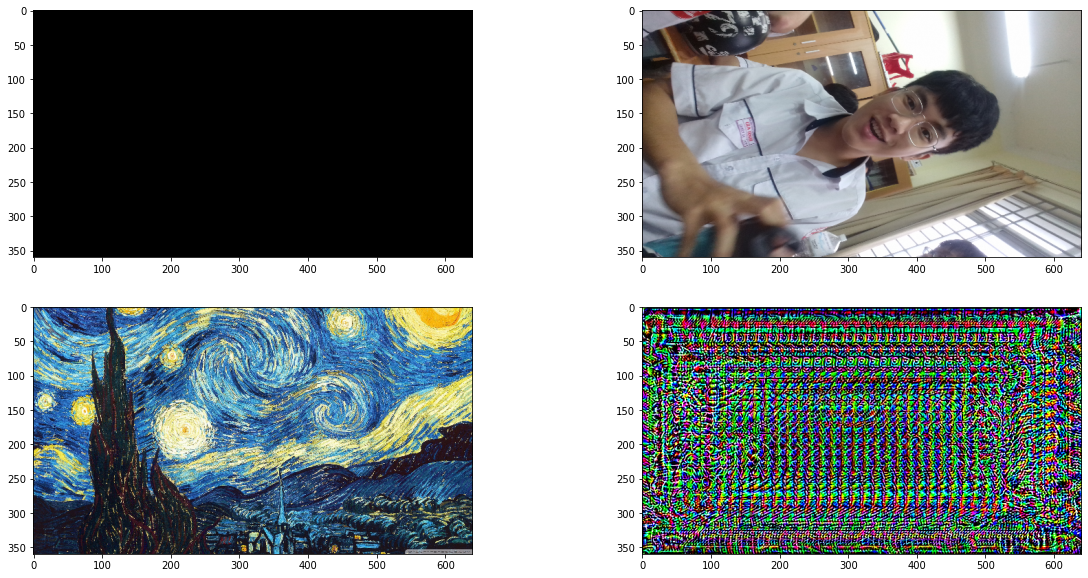

In [26]:
fig,ax=plt.subplots(2,2,figsize=(20,10))
ax[1,1].imshow(post_pross(ima_new.numpy()))
ax[0,1].imshow(org_image.numpy())
ax[1,0].imshow(st_image.numpy())
ax[0,0].imshow(np.zeros((H,L,3)))

In [27]:
matplotlib.image.imsave('art_style.jpg',post_pross(ima_new.numpy()))

# Tạo model dùng Keras

In [28]:
class ascent(keras.layers.Layer):
  def __init__(self):
    super(ascent,self).__init__()
    self.image_init=tf.Variable(initial_value=tf.zeros_like(tf.reshape(org_image,(1,H,L,3))),dtype=tf.float32,trainable=True)
  def call(self,input):
    return self.image_init*1

In [29]:
print(tf.shape(org_image))

tf.Tensor([360 640   3], shape=(3,), dtype=int32)


In [30]:
def get_style_ascent(org_image,st_image,layer_idx=[-2,-2,-6,-10,-14,0]):
  ##Get VGG
  my_new_vgg=keras.applications.VGG16(include_top=False)
  my_new_vgg.trainable=False
  ##Build Model
  model_zoo=[]
  for i in layer_idx:
    model_zoo.append(get_layer_feature(my_new_vgg,i))
  input=keras.Input((1))
  split=ascent()(input)
  branch0=model_zoo[0](split)
  branch1=model_zoo[1](split)
  branch2=model_zoo[2](split)
  branch3=model_zoo[3](split)
  branch4=model_zoo[4](split)
  branch5=model_zoo[5](split)
  style_transfer=keras.Model(inputs=input,outputs=[branch0,branch1,branch2,branch3,branch4,branch5])
  style_transfer.summary()
  ##config ground truth
  style_ground_truth=get_layer_feature(my_new_vgg,layer_idx[:-1])(tf.reshape(st_image,(1,H,L,3)))
  content_ground_truth=get_layer_feature(my_new_vgg,[layer_idx[1]])(tf.reshape(org_image,(1,H,L,3)))
  style_ground_truth_gram=[]
  for i in style_ground_truth : 
    style_ground_truth_gram.append(gram_matrix(i[0]))
  ##config losses
  def var_loss(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_pred-tf.constant(org_image)))
  def style_loss0_(y_true,y_pred):
    return tf.reduce_mean(tf.square(gram_matrix(y_pred[0])-tf.constant(style_ground_truth_gram[1])))
  def style_loss1_(y_true,y_pred):
    return tf.reduce_mean(tf.square(gram_matrix(y_pred[0])-tf.constant(style_ground_truth_gram[2])))
  def style_loss2_(y_true,y_pred):
    return tf.reduce_mean(tf.square(gram_matrix(y_pred[0])-tf.constant(style_ground_truth_gram[3])))
  def style_loss3_(y_true,y_pred):
    return tf.reduce_mean(tf.square(gram_matrix(y_pred[0])-tf.constant(style_ground_truth_gram[4])))
  def content_loss(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_pred[0]-tf.constant(content_ground_truth)))
  loss_matrix=[content_loss,style_loss0_,style_loss1_,style_loss2_,style_loss3_,var_loss]
  return style_transfer,loss_matrix


In [39]:
style_transfer,loss_matrix=get_style_ascent(org_image,st_image)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 ascent_2 (ascent)              (1, 360, 640, 3)     691200      ['input_7[0][0]']                
                                                                                                  
 model_19 (Functional)          (None, None, None,   14714688    ['ascent_2[0][0]']               
                                512)                                                              
                                                                                                  
 model_20 (Functional)          (None, None, None,   14714688    ['ascent_2[0][0]']        

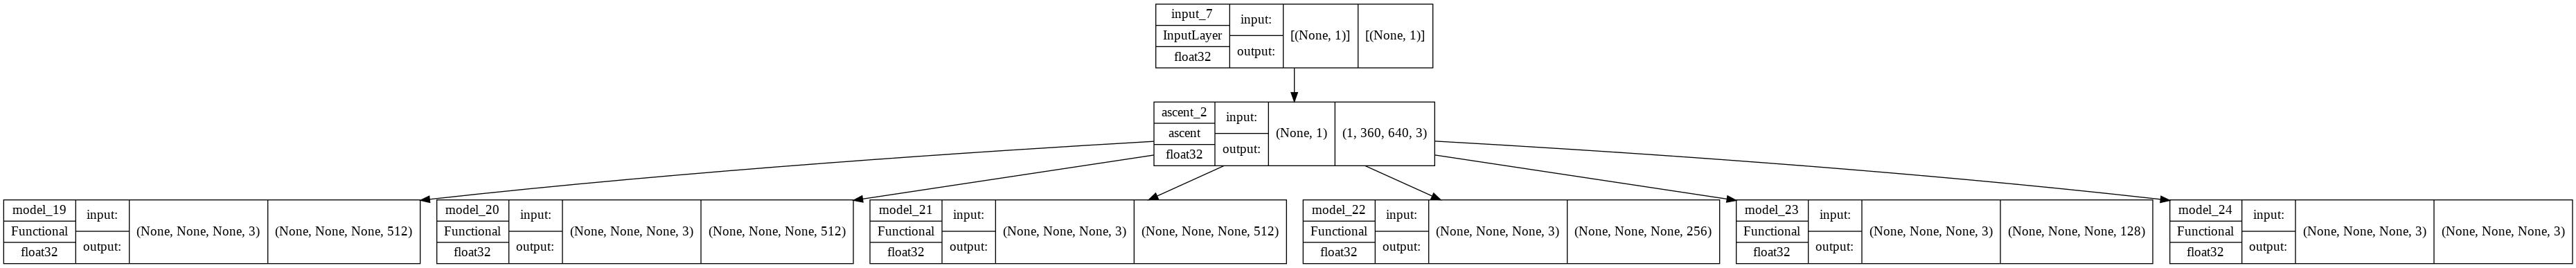

In [40]:
tf.keras.utils.plot_model(
    style_transfer,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

# Train


In [42]:
style_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1),
    loss=loss_matrix,loss_weights=[1e5,225,1e-2,1e-4,1e-5,1e6]
)

In [43]:
print(type(tf.reshape(org_image,(H,L,3))))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [44]:
epochs=900
x=tf.ones((1,1),dtype=tf.float32)
y=tf.ones((1,6),dtype=tf.float32)
style_transfer.fit(x,y,epochs=epochs)

Epoch 1/900
1/1 [==============================] - 6s 6s/step - loss: 43507116.0000 - model_19_loss: 0.0575 - model_20_loss: 7688.7817 - model_21_loss: 2629992.0000 - model_22_loss: 238353973248.0000 - model_23_loss: 1754947649536.0000 - model_24_loss: 0.3602
Epoch 2/900
1/1 [==============================] - 1s 902ms/step - loss: 2357062400.0000 - model_19_loss: 0.0639 - model_20_loss: 7667.5845 - model_21_loss: 6735974.0000 - model_22_loss: 13660860710912.0000 - model_23_loss: 98778258341888.0000 - model_24_loss: 1.3950
Epoch 3/900
1/1 [==============================] - 1s 868ms/step - loss: 1607702016.0000 - model_19_loss: 0.0670 - model_20_loss: 6252.8550 - model_21_loss: 4372251.5000 - model_22_loss: 7230969610240.0000 - model_23_loss: 88177264033792.0000 - model_24_loss: 1.3751
Epoch 4/900
1/1 [==============================] - 1s 854ms/step - loss: 1143996288.0000 - model_19_loss: 0.0758 - model_20_loss: 6811.2578 - model_21_loss: 8286725.0000 - model_22_loss: 5693895081984.0000

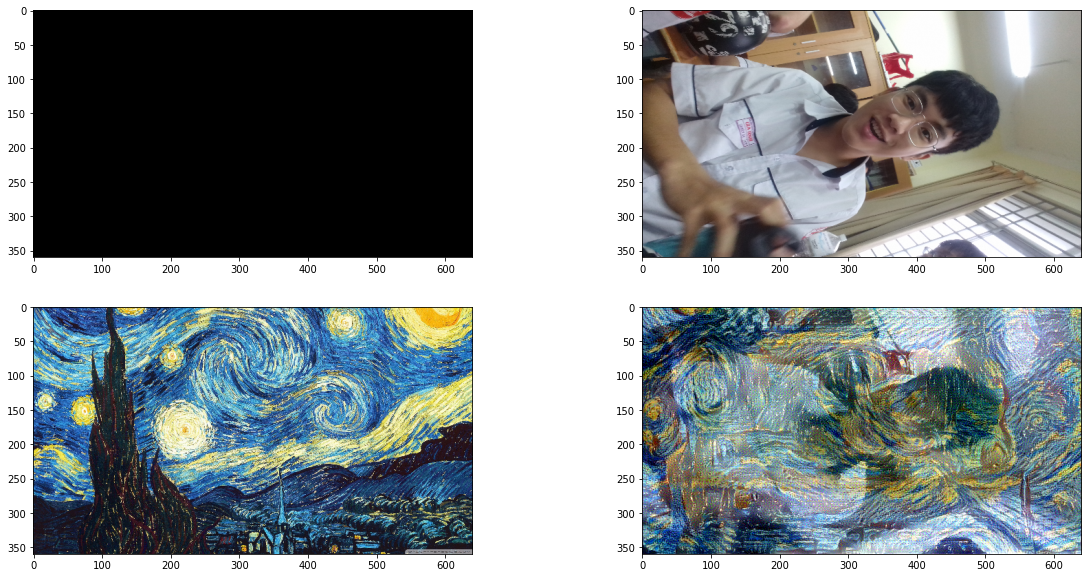

In [50]:
result=style_transfer.layers[1].get_weights()[0][0]
fig,ax=plt.subplots(2,2,figsize=(20,10))
ax[1,1].imshow(post_pross(result))
ax[0,1].imshow(org_image)
ax[1,0].imshow(st_image)
ax[0,0].imshow(tf.zeros_like(st_image))

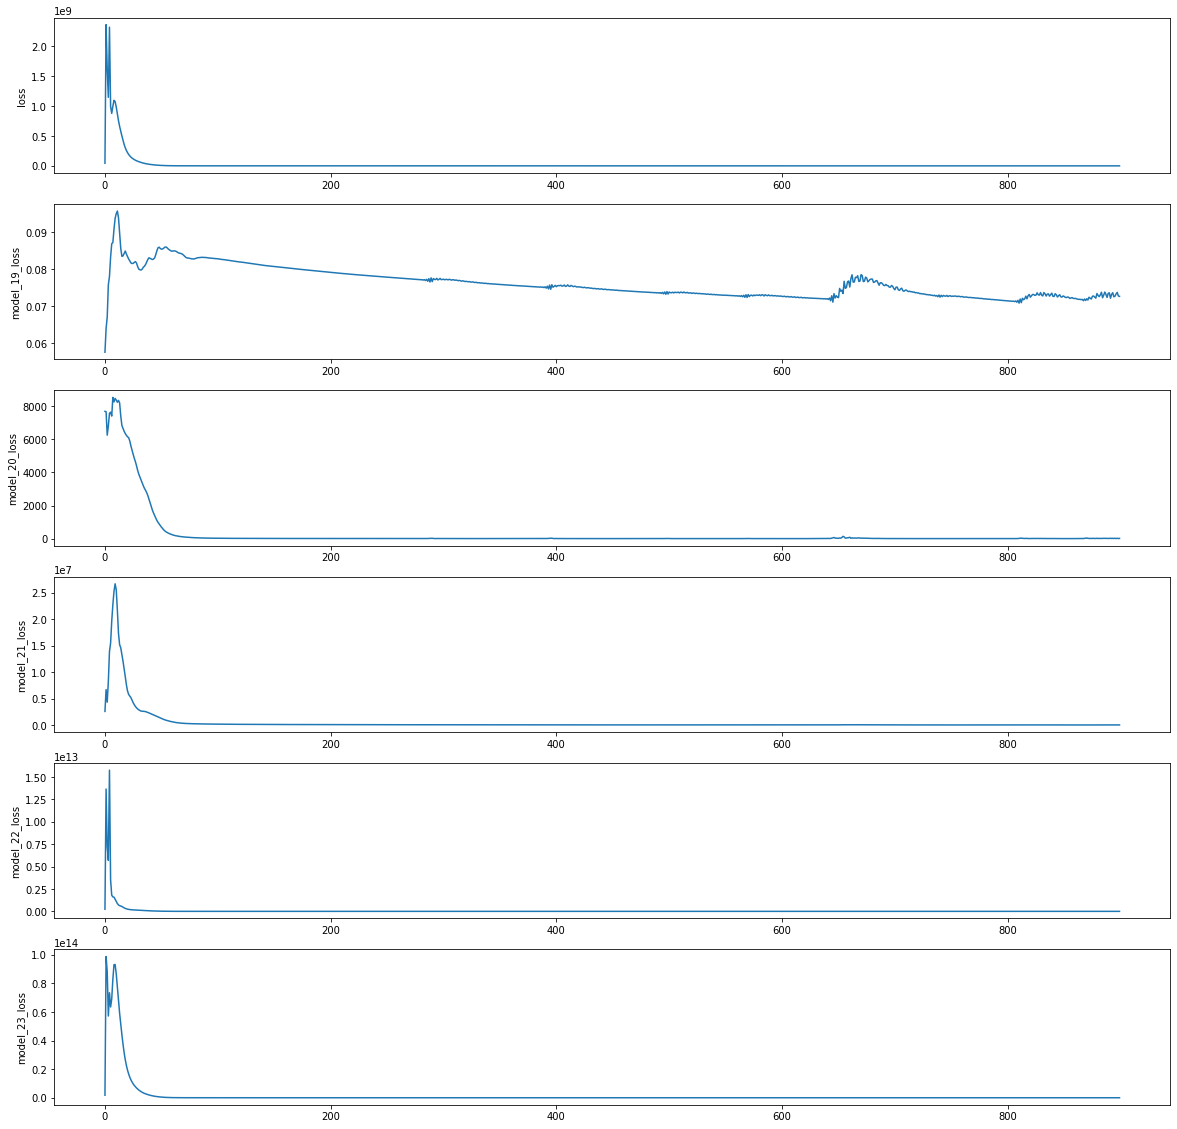

In [46]:
loss_data=pd.DataFrame(style_transfer.history.history)
fig,ax=plt.subplots(len(loss_matrix),1,figsize=(20,20))
for i in range(len(loss_matrix)):
  sns.lineplot(data=loss_data.iloc[:,i],ax=ax[i])


# STYLE khác


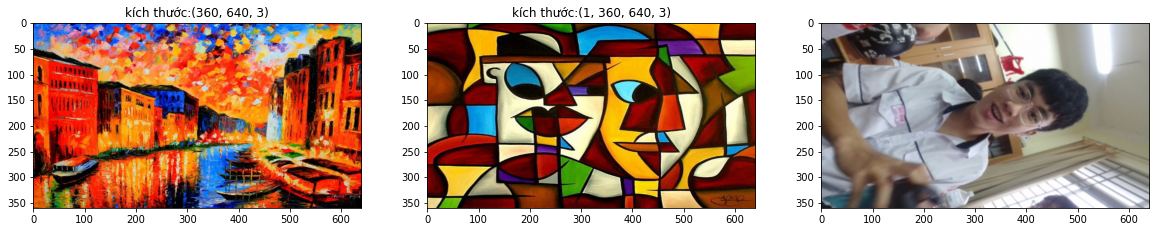

In [68]:
cubic_image=tf.constant(plt.imread('//content//drive//MyDrive//Colab Notebooks//cubic.jpg'))/255
modern_image=tf.constant(plt.imread('//content//drive//MyDrive//Colab Notebooks//modern.jpg'))/255
cubic_image=tf.constant(cv2.resize(cubic_image.numpy(),(L,H)))
modern_image=tf.constant(cv2.resize(modern_image.numpy(),(L,H)))
fig,ax=plt.subplots(1,3,figsize=(20,40))
ax[0].imshow(modern_image.numpy())
ax[0].set_title('kích thước:'+str(modern_image.shape))
modern_image=tf.reshape(modern_image,(1,H,L,3))
ax[1].imshow(cubic_image.numpy())
cubic_image=tf.reshape(cubic_image,(1,H,L,3))
ax[1].set_title('kích thước:'+str(cubic_image.shape))
org_image_blur=cv2.GaussianBlur(org_image.numpy(),(3,3),cv2.BORDER_DEFAULT)
ax[2].imshow(org_image_blur)
org_image_blur=tf.reshape(tf.constant(org_image_blur,dtype=tf.float32),(1,H,L,3))

In [69]:
cubic_transfer,cubic_loss=get_style_ascent(org_image_blur,cubic_image)

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 ascent_4 (ascent)              (1, 360, 640, 3)     691200      ['input_11[0][0]']               
                                                                                                  
 model_37 (Functional)          (None, None, None,   14714688    ['ascent_4[0][0]']               
                                512)                                                              
                                                                                                  
 model_38 (Functional)          (None, None, None,   14714688    ['ascent_4[0][0]']        

In [70]:
cubic_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1),
    loss=cubic_loss,loss_weights=[5e5,225,1e-2,1e-4,1e-5,5e7]
)

In [71]:
epochs=450
x=tf.ones((1,1),dtype=tf.float32)
y=tf.ones((1,6),dtype=tf.float32)
cubic_transfer.fit(x,y,epochs=epochs)

Epoch 1/450
1/1 [==============================] - 5s 5s/step - loss: 39460208.0000 - model_37_loss: 0.0508 - model_38_loss: 13572.6084 - model_39_loss: 4831538.5000 - model_40_loss: 147383484416.0000 - model_41_loss: 366790213632.0000 - model_42_loss: 0.3585
Epoch 2/450
1/1 [==============================] - 1s 889ms/step - loss: 7720218112.0000 - model_37_loss: 0.0653 - model_38_loss: 12901.6162 - model_39_loss: 27341414.0000 - model_40_loss: 62730895622144.0000 - model_41_loss: 137778926977024.0000 - model_42_loss: 1.3226
Epoch 3/450
1/1 [==============================] - 1s 876ms/step - loss: 6107317760.0000 - model_37_loss: 0.0641 - model_38_loss: 12345.7959 - model_39_loss: 16034256.0000 - model_40_loss: 41521596334080.0000 - model_41_loss: 188514738110464.0000 - model_42_loss: 1.3408
Epoch 4/450
1/1 [==============================] - 1s 853ms/step - loss: 3103172096.0000 - model_37_loss: 0.0661 - model_38_loss: 10525.6992 - model_39_loss: 12286704.0000 - model_40_loss: 848737337

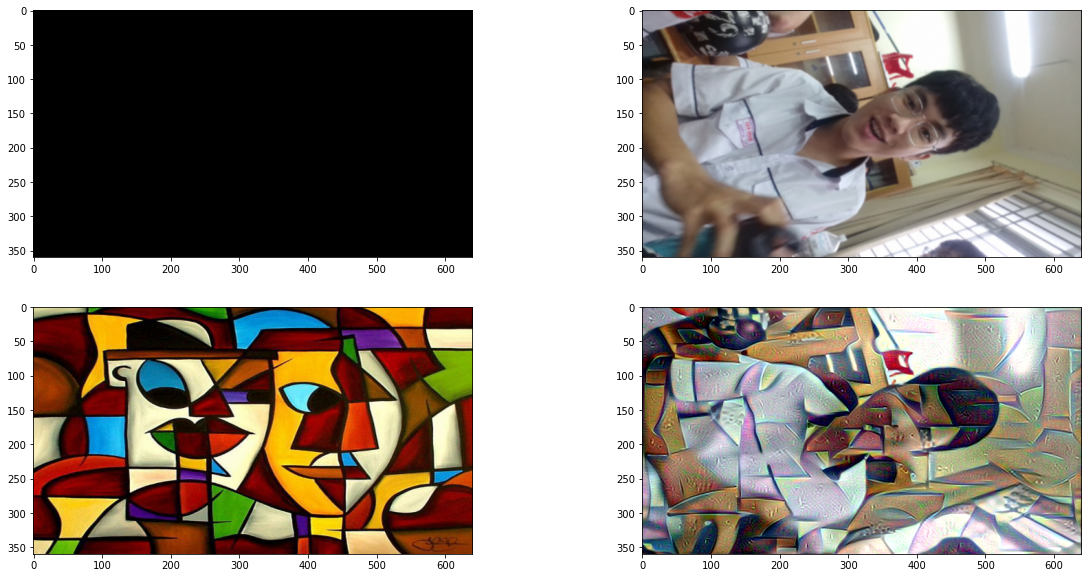

In [72]:
result=cubic_transfer.layers[1].get_weights()[0][0]
fig,ax=plt.subplots(2,2,figsize=(20,10))
ax[1,1].imshow(post_pross(result))
ax[0,1].imshow(org_image_blur[0])
ax[1,0].imshow(cubic_image[0])
ax[0,0].imshow(tf.zeros_like(st_image))

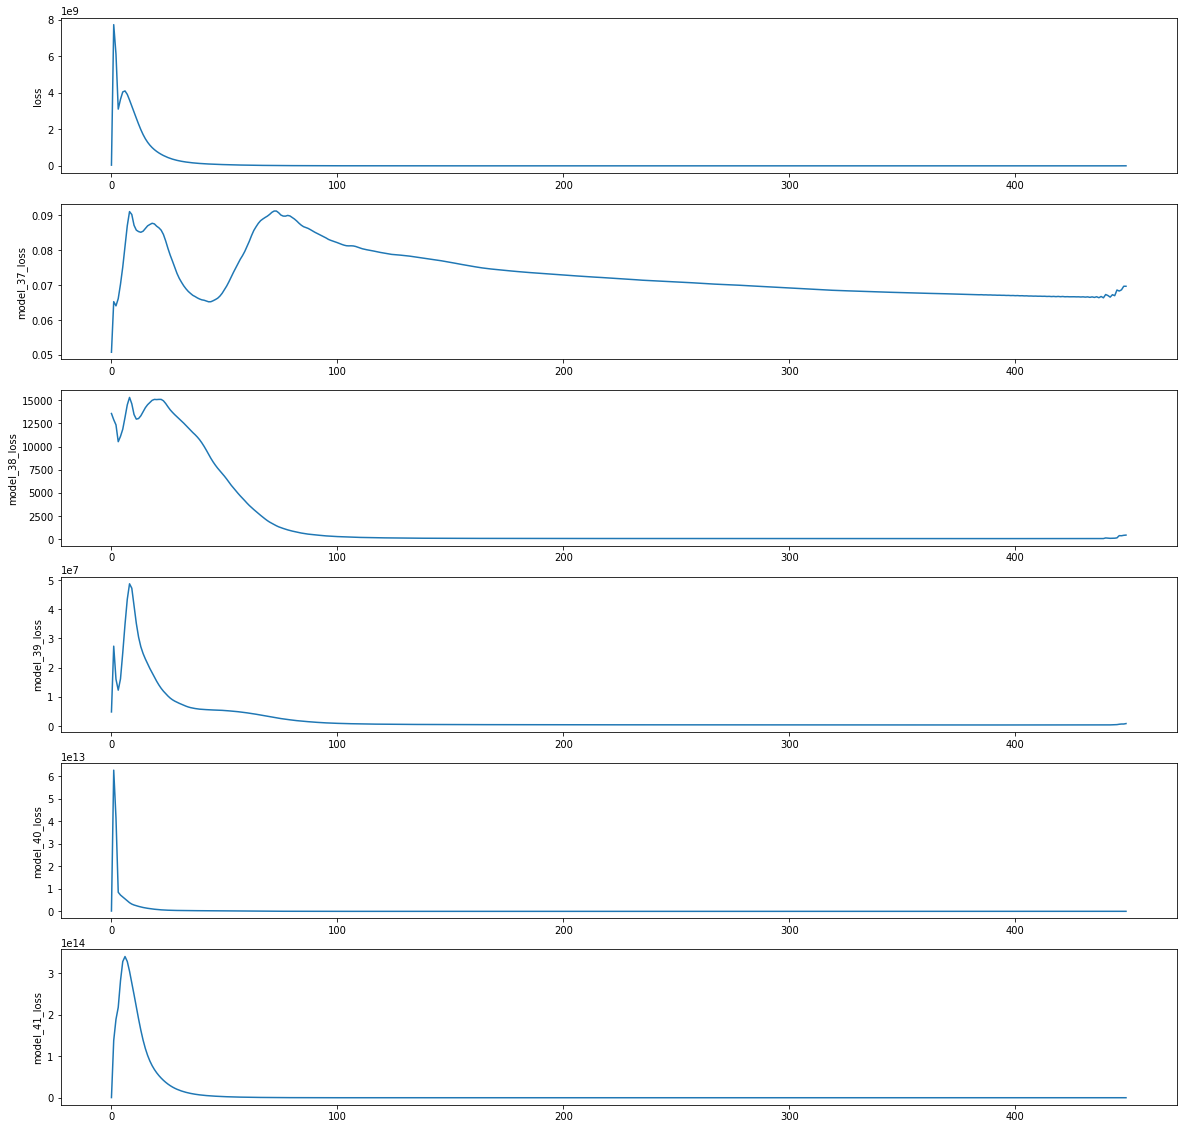

In [73]:
loss_data=pd.DataFrame(cubic_transfer.history.history)
fig,ax=plt.subplots(len(cubic_loss),1,figsize=(20,20))
for i in range(len(cubic_loss)):
  sns.lineplot(data=loss_data.iloc[:,i],ax=ax[i])

# Huấn luyện bộ style transfer
